# Grover's Algorithm

This is an implementation of Grover's algorithm using Qiskit to connect to IBM's quantum computers remotely.

### TODO:

- [x] Implement the automation for which values to search for rather than individual bits manually

- [x] Compile results

  - [x] Save results

  - [x] Load results

- [x] Job helper functions
  
  - [x] getJob()

  - [x] addJob()

  - [x] checkJobs()

- [x] Research how Oracle vs search values are distinguished

- [x] Try Wolfram version of circuit

- [x] Display statvector functionally

- [x] Write function for running on simulator

- [x] Write function for running on actual IBMQ computer

## Library imports

In [5]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
import os
import time

# importing Qiskit
from qiskit import transpile #, execute, providers
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
# from qiskit_ibm_provider import IBMProvider, least_busy

# from qiskit_ibm_runtime import QiskitRuntimeService

# import basic plot tools
from qiskit.visualization import plot_histogram # , array_to_latex
# from qiskit.tools.monitor import job_monitor

# Import algorithms
# from qiskit.algorithms import AmplificationProblem, Grover 
# ^ This will throw an error because numpy is funny and has a typo
# If you go to /path-to-venv/.venv/lib/python3.10/site-packages/numpy/lib/arraypad.py:489 
#   and change np.round() to np.round_(), it'll with compile no issue

# Import circuit elements
from qiskit.circuit.library import Barrier, GroverOperator, PhaseOracle
from qiskit.primitives import Sampler
from qiskit.quantum_info import Statevector
from qiskit.exceptions import MissingOptionalLibraryError

# USER_TOKEN = 'fe3bbd733cfc93be9e23691af3757537592f818753ab6c68b76016701824c090bd4f716e8a1239759d0eb918aa34db6f38754bd377b222684065255f56227902'
# IBMProvider.save_account(token=USER_TOKEN, overwrite=True)

## Function definitions

In [24]:

# Get an array representation of the qubits to mark/check
def intToCircuitInput(x):
  # Convert decimal input to binary, clear 0b prefix
  b = bin(x)[2:]
  out = []
  # Run through the binary backwards, adding the index of each 1 to an array
  for i, a in enumerate(b[::-1]):
    if (a == '1'):
      out.append(int(i))
  return out

# Sets up which qubits are read by the oracle
# @param input - binary number string
# @param inputs - decimal integer to search for their binary equivalent
# @param n_bits - The number of bits in the quantum circuit
# @return - A binary vector representing the queried state, reversed to respect qiskit order
#          '01011' => [1, 1, 0, 1, 0]
#          9 => [1, 0, 0, 1]
def convertQuery(input, n_bits):
  if isinstance(input, str):
    n_zeroes = n_bits - len(input) # How many zeroes to prepend
    bin_str = ('0' * n_zeroes) + input
    q_out = []
    for c in bin_str:
      q_out.append(int(c))
    q_out = q_out[::-1]
    return q_out
  if isinstance(input, int):
    b = bin(input)[2:] # Get binary string of the number
    return convertQuery(b, n_bits)
  else:
     print("Bad input to convertQuery")

# Sets up which qubits are read by the oracle
# @param inputs - Array of binary number strings and/or integers
# @param n_bits - The number of bits in the quantum circuit
# @return - A two-dimensional binary vector:
#          convertQueries(['1001', 13], 5) => [ [0, 1, 0, 0, 1], [0, 1, 1, 0, 1] ]
def convertQueries(inputs, n_bits):
  out = []
  for query in inputs:
    out.append(convertQuery(query, n_bits))
  return out

def numIterations(n_bits, n_inputs):
  return math.floor(((math.pi/4)*math.sqrt(pow(2, n_bits)/n_inputs))-0.5)

def initialize_s(qc, qubits):
    # Apply a H-gate to 'qubits' in qc
    for q in qubits:
        qc.h(q)
    return qc

# Multi-control Toffoli (Multi-CNOT gate)
def mct(qc, ctrl, anc, tgt):
    n_ctrl = len(ctrl)
    # Check fits query
    qc.ccx(ctrl[0], ctrl[1], anc[0])
    for i in range(2, n_ctrl):
      qc.ccx(ctrl[i], anc[i-2], anc[i-1])
    # Send result to target
    qc.cz(anc[n_ctrl-2], tgt[0])
    # Reset to original state
    for i in range(n_ctrl-1, 1, -1):
      qc.ccx(ctrl[i], anc[i-2], anc[i-1])
    qc.ccx(ctrl[0], ctrl[1], anc[0])    
    return qc


def oracle(query, ctrl, anc, tgt, n_ctrl):
    qc = QuantumCircuit(ctrl, anc, tgt)
    # Modify desired state to fit query
    # |0101...101> -> |1111...111> (If fits)
    for i, s in enumerate(query):
      if (s == 0):
         qc.x(ctrl[i])
    # Multi-CNOT
    qc = mct(qc, ctrl, anc, tgt)
    # Undo state modification
    for i, s in enumerate(query):
      if (s == 0):
         qc.x(ctrl[i])
    U_s = qc.to_gate()
    U_s.name = " U$_f$ "
    return U_s

# Source for diffuser: https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm
def diffuser(ctrl, anc, tgt):
    qc = QuantumCircuit(ctrl, anc, tgt)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in ctrl:
        qc.h(qubit)
    for qubit in tgt:
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in ctrl:
        qc.x(qubit)
    for qubit in tgt:
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(tgt[0])
    qc = mct(qc, ctrl, anc, tgt)
    # qc.mct(ctrl, tgt[0])  # multi-controlled-toffoli
    qc.h(tgt[0])
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in ctrl:
        qc.x(qubit)
    for qubit in tgt:
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in ctrl:
        qc.h(qubit)
    for qubit in tgt:
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = " 2A-I "
    return U_s


## Define Parameters
This is where inputs for the circuit are defined.

In [25]:
n_ctrl = 5 # Bitsize of values, >= 2
n_ancl = n_ctrl-1
n_anc2 = 4 # Bitsize of addressing space
n = n_ctrl+n_ancl+1 # Total number of qubits
search_vals = [24] # Inputs for which f(x) = 1
query = convertQuery(search_vals[0], n_ctrl)

# Circuit Definitions
Circuits are defined and displayed here


## Fully Custom Circuit

iterations: 1


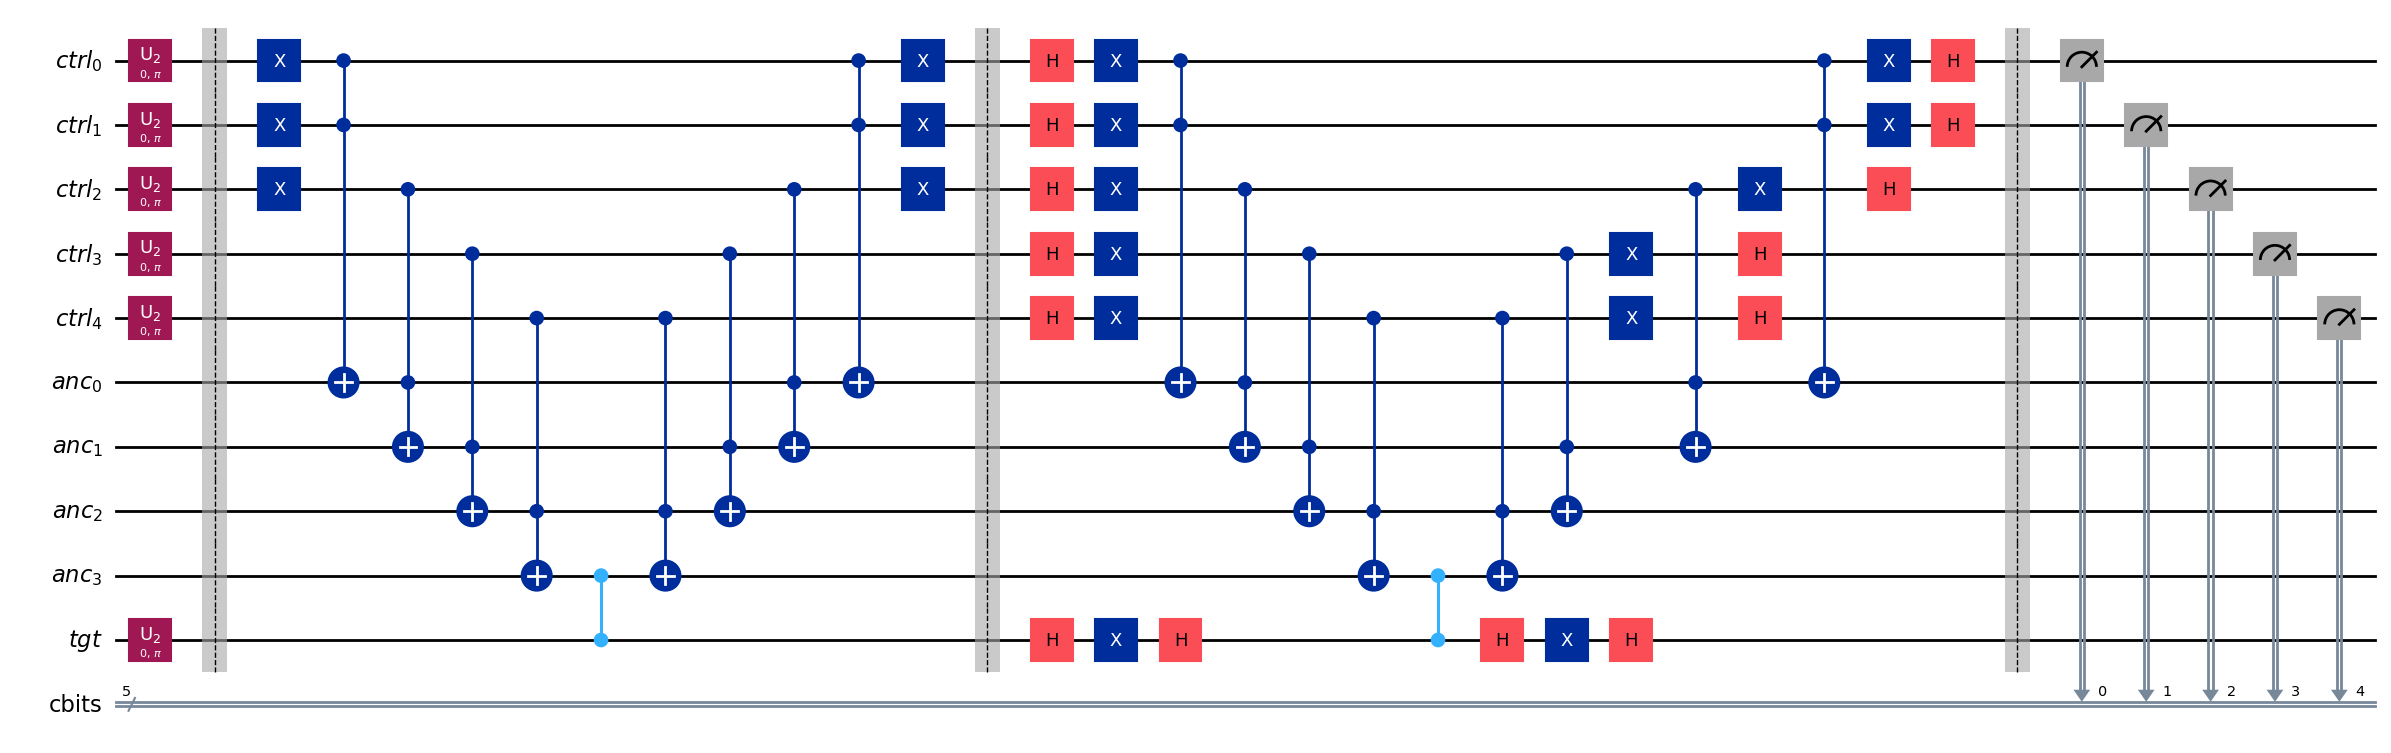

In [28]:
ctrl = QuantumRegister(n_ctrl, 'ctrl')
anc = QuantumRegister(n_ancl, 'anc')
anc2 = QuantumRegister(n_anc2, 'anc')
tgt = QuantumRegister(1, 'tgt')
cbits = ClassicalRegister(n_ctrl, 'cbits')


grover_circuit = QuantumCircuit(ctrl, anc, tgt, cbits)
grover_circuit = initialize_s(grover_circuit, ctrl)
grover_circuit = initialize_s(grover_circuit, tgt)

# Add the rest of the circuit
num_iterations = numIterations(n_ctrl, len(search_vals))
num_iterations = 1
print(f'iterations: {num_iterations}')
for i in range(0, num_iterations):
  grover_circuit.barrier()
  grover_circuit.append(oracle(query, ctrl, anc,  tgt, n_ctrl), grover_circuit.qubits)
  grover_circuit.barrier()
  grover_circuit.append(diffuser(ctrl, anc, tgt), grover_circuit.qubits)
  grover_circuit.barrier()

grover_circuit.measure(ctrl, cbits)

# Display the circuit diagram
grover_circuit.decompose().draw(output='mpl', style='iqx-dark', fold=-1) # Show the contents of custom circuit components
# grover_circuit.draw(output='mpl', style='iqx-dark', fold=-1) # Hide the contents of custom circuit components

# Job Helper Functions

In [7]:
# Check the jobs/ folder for job IDs that have been recorded
# Returns job of the number indicated
def getJob(provider, job_num):
  filepath = os.getcwd() +  f'/jobs/job{str(job_num)}.txt'
  if (os.path.isfile(filepath)):
    f = open(filepath,'r')
    if f.readable(): 
      job_id = f.readline()
    f.close()
    job = QiskitRuntimeService().job(job_id=job_id)
    print(f'Job {job_num}:\n \
      Status: {job.status().value}\n \
      Backend: {job.backend()}\n \
      ID: {job.job_id()}')
    return job
  else:
    return None

# Display status of all jobs with IDs in the 'jobs/' folder
def checkJobs(provider):
  # Go through all current saved job IDs
  i = 1
  while True:
    if (getJob(provider, i)):
      i += 1
      continue;
    else:
      break;

# Add a job to IBM queue
# Saves the Job ID in 'jobs/jobX.txt' where x is the new count of jobs. 
# i.e. job1.txt, job2.txt, etc.
def addJob(device, provider, transpiled_circuit, num_shots):
  i = 1
  # Get number for current job
  filepath = os.getcwd() +  f'/jobs/job{str(i)}.txt'
  while os.path.isfile(filepath):
    i += 1
    filepath = os.getcwd() +  f'/jobs/job{str(i)}.txt'
  job = device.run(transpiled_circuit, shots=num_shots)
  f = open(filepath, 'w')
  f.write(job.job_id())
  f.close()
  print(f'Job {i} Successfully Scheduled')
  print(f'Job {i}:\n \
    Status: {job.status().value}\n \
    Backend: {job.backend()}\n \
    ID: {job.job_id()}')
  return job


# Set Device, Transpile Circuit, Send to IBMQ

In [254]:
### Simulator -- Uncomment to run as simulation
if 'provider' not in locals():
  provider = IBMProvider()
if 'backend' not in locals(): 
  backend = provider.get_backend('ibmq_qasm_simulator')
  print("Running on current least busy device: ", backend)

### Real QC -- Uncomment to run on least busy QC
# provider = IBMProvider(instance="ibm-q/open/main")
# backend = least_busy(provider.get_backend(simulator=False, filters=lambda b: b.configuration().n_qubits >= n))

### Run our circuit on the least busy backend. Monitor the execution of the job in the queue
transpiled_grover_circuit = transpile(grover_circuit, backend, optimization_level=3)

print("Finished transpiling")

Finished transpiling


# Run Job

In [122]:
job = addJob(backend, provider, transpiled_grover_circuit, 1024)

Job 22 Successfully Scheduled
Job 22:
     Status: job is actively running
     Backend: <IBMBackend('ibmq_qasm_simulator')>
     ID: chfdbkn9targ2vq8rmng


# Helper Functions for Converting Job Results

In [9]:

def hexToBin(hex, n_bits):
  x = hex[2:] # Remove prefix
  scale = 16 # Hexadecimal scale
  return bin(int(x, scale))[2:].zfill(n_bits)

def dictHexToBin(answer, n_bits):
  out = {}
  for x in answer:
    out[hexToBin(x, n_bits)] = answer[x]
  return out

def saveResults(results):
  filepath = os.getcwd() + '/results', '+a'
  if (os.path.isfile(filepath)):
    f = open(filepath)
    f.write(f'{str(results)}\n')
    f.close()
  else:
    print(f"File \'{filepath}\' does not exist")

def getResults():
  filepath = os.getcwd() + '/results', '+a'
  if (os.path.isfile(filepath)):
    f = open(os.getcwd() + '/results', 'r')
    s = f.read().split('\n')
    f.close()
  else:
    print(f"Failed to save results in {filepath}")
  d = {}
  for l in s:
    try:
      d.append(dict(l))
    except Exception as e:
      print(f'Error in getResults\n \
            Failed to convert string to dict; \n {e}')

def saveAllResults():
  # Go through all current saved job IDs
  i = 1
  while True:
    job = getJob(provider, i)
    if (job):
      saveResults(dictHexToBin(job.result()['results'][0]['data']['counts']))
    else:
      break;
    i += 1

# See Job Results



## All Job Results

In [259]:
# Run through every job and pull the results
i = 1
while(job != None):
  try:
    job = getJob(provider, i)
  except:
    pass
  if (job.status() != job.status().DONE):
    print("Job not done")
    time.sleep(3)
    pass
  # Get the results from the computation
  results = job.result()
  answer = results.get_counts()
  print(answer)
  plot_histogram(answer, color='midnightblue', filename=f'out{i}')
  i += 1

## Specific Result

Job 41:
       Status: job has successfully run
       Backend: <IBMBackend('ibmq_qasm_simulator')>
       ID: chfeaqb66hmpifv9hth0
{'11001': 28, '00001': 23, '01101': 30, '11010': 27, '00100': 23, '00011': 24, '10000': 28, '10101': 18, '11011': 33, '10011': 32, '11100': 32, '11110': 38, '00010': 27, '01110': 22, '01010': 28, '10001': 31, '01001': 29, '00101': 181, '01100': 26, '01000': 22, '00110': 26, '10100': 28, '11101': 31, '00111': 27, '01011': 28, '00000': 24, '01111': 21, '10110': 29, '10010': 32, '11111': 28, '10111': 18, '11000': 30}


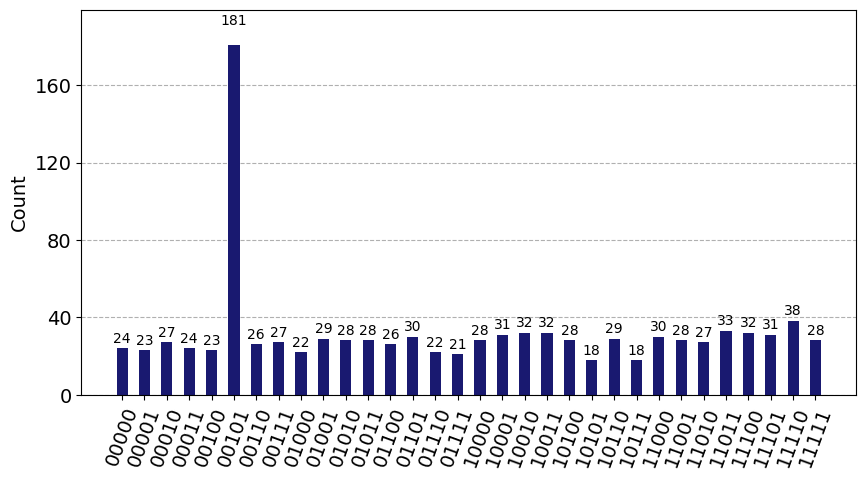

In [251]:
job_n = 41;
job = getJob(provider, job_n)
if (job.status() != job.status().DONE):
  print("Job not done")
  time.sleep(3)
  pass;
# Get the results from the computation
results = job.result()
answer = results.get_counts()
print(answer)
plot_histogram(answer, color='midnightblue', figsize=(10, 5))

## Quickly send and check a job (Mainly for testing)

Job 47 Successfully Scheduled
Job 47:
     Status: job is actively running
     Backend: <IBMBackend('ibmq_qasm_simulator')>
     ID: chfeuh366hmpifva346g
Job not done
{'01100': 4, '00000': 9, '01011': 3, '00111': 6, '00010': 5, '11111': 6, '10110': 3, '10010': 6, '01010': 3, '10001': 7, '01110': 3, '11001': 4, '10100': 3, '11101': 6, '11100': 2, '11110': 9, '10101': 4, '10000': 4, '01001': 8, '00101': 851, '11011': 7, '01000': 3, '01101': 11, '00001': 5, '00011': 10, '00100': 6, '00110': 8, '10011': 4, '01111': 7, '11010': 4, '10111': 10, '11000': 3}


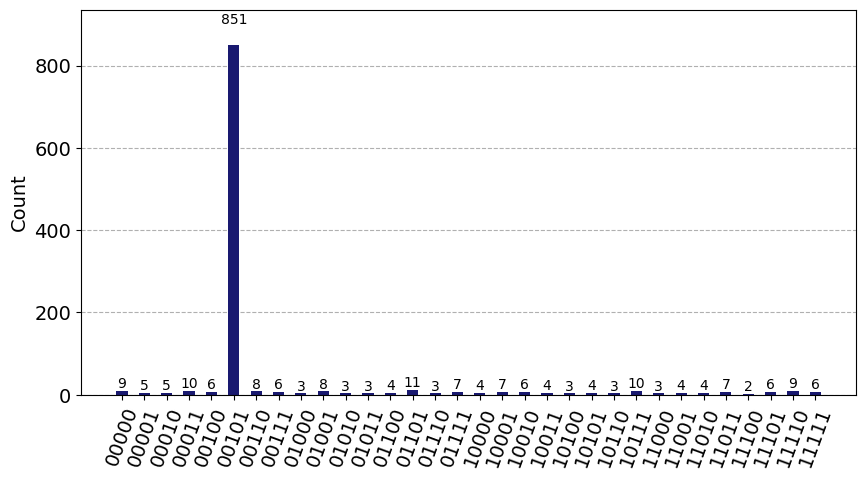

In [263]:
transpiled_grover_circuit = transpile(grover_circuit, backend, optimization_level=3)
job = addJob(backend, provider, transpiled_grover_circuit, 1024)
while (job.status() != job.status().DONE):
  print("Job not done")
  time.sleep(1)
  pass;
# Get the results from the computation
results = job.result()
answer = results.get_counts()
print(answer)
plot_histogram(answer, color='midnightblue', figsize=(10,5))